In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Image
import scipy
import time

# Make sure that caffe is on the python path:
caffe_root = '/home/axj232/caffe/' 
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
#load our fully convolutional network 
net_full_conv = caffe.Net('deploy_full.prototxt', 
                          'full_convolutional_net.caffemodel', caffe.TEST)

In [3]:
#load our mean file and get it into the right shape
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})

a = caffe.io.caffe_pb2.BlobProto()
file = open('DB_train_1.binaryproto','rb')
data = file.read()
a.ParseFromString(data)
means = a.data

means = np.asarray(means)
means = means.reshape(1, 64, 64)
means.shape

(1, 64, 64)

In [4]:
means.mean(1).mean(1).shape

(1,)

In [5]:
transformer.set_mean('data',means.mean(1).mean(1))
#transformer.set_channel_swap('data', (2,1,0))
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)

In [6]:
#set the mode to use the GPU
caffe.set_device(0)
caffe.set_mode_gpu()

In [7]:
im_orig = caffe.io.load_image('12884_500_f00092_original_H.png',color=False)

nrow_in=im_orig.shape[0] #we'll be doing padding later, 
ncol_in=im_orig.shape[1] #so lets make sure we know the original size

print im_orig.shape
#IMPORTANT: note here that the shape is 2000 x 2000, which is the same size 
#as we specified in our deploy_full text!


(2000, 2000, 1)


In [8]:
patch_size = 64 #the patch size that trained the network
hpatch_size = patch_size / 2 #this is the size of the edges around the image

# 2032 x 2032 input file , 501 x 501 output = 3.99 <-- this round error 
# is why we need to use interpoliation
displace_factor = 9

im_orig = np.lib.pad(im_orig, ((hpatch_size, hpatch_size+displace_factor), \
                               (hpatch_size, hpatch_size+displace_factor), \
                               (0, 0)),  'symmetric')

print im_orig.shape 
#IMPORTANT: note here that the shape is 2032 x 2032, which is the same size 
#as we specified in our deploy_full text!

start=time.time()

xx_all=np.empty([0,0])
yy_all=np.empty([0,0])
zinter_all=np.empty([0,0])

(2073, 2073, 1)


In [9]:
for r_displace in xrange(0,displace_factor): # loop over the receptor field
    for c_displace in xrange(0,displace_factor):
        print "Row + Col displace:\t (%d/ %d) (%d/ %d) " %( r_displace, displace_factor, \
                                                           c_displace, displace_factor)
        
        
        im= im_orig[0+r_displace:-displace_factor+r_displace,0+c_displace \
                    :-displace_factor+c_displace,:] #displace the image
        out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)])) #get the output 
        #i'm only interested in the "positive class channel"
        # the negative is simply 1- this channel
        output_sub_image=out['prob'][0][1,:,:] 
        
        nrow_out=output_sub_image.shape[0]
        ncol_out=output_sub_image.shape[1]
        
        start_spot_row=r_displace
        start_spot_col=c_displace
        
        end_spot_row=nrow_in+r_displace
        end_spot_col=ncol_in+c_displace
        
        rinter=np.linspace(start_spot_row,end_spot_row,num=nrow_out)
        cinter=np.linspace(start_spot_col,end_spot_col,num=ncol_out)
        
        xx,yy=np.meshgrid(cinter,rinter)
        
        xx_all=np.append(xx_all,xx.flatten())
        yy_all=np.append(yy_all,yy.flatten())
        zinter_all=np.append(zinter_all,output_sub_image.flatten())
        
        print "Time since beginning:\t %f"% (time.time()-start)
print "Total time:\t %f"%(time.time()-start)

Row + Col displace:	 (0/ 9) (0/ 9) 
Time since beginning:	 0.864212
Row + Col displace:	 (0/ 9) (1/ 9) 
Time since beginning:	 1.580228
Row + Col displace:	 (0/ 9) (2/ 9) 
Time since beginning:	 2.288354
Row + Col displace:	 (0/ 9) (3/ 9) 
Time since beginning:	 2.999745
Row + Col displace:	 (0/ 9) (4/ 9) 
Time since beginning:	 3.710064
Row + Col displace:	 (0/ 9) (5/ 9) 
Time since beginning:	 4.421285
Row + Col displace:	 (0/ 9) (6/ 9) 
Time since beginning:	 5.133603
Row + Col displace:	 (0/ 9) (7/ 9) 
Time since beginning:	 5.845871
Row + Col displace:	 (0/ 9) (8/ 9) 
Time since beginning:	 6.559810
Row + Col displace:	 (1/ 9) (0/ 9) 
Time since beginning:	 7.276339
Row + Col displace:	 (1/ 9) (1/ 9) 
Time since beginning:	 7.992675
Row + Col displace:	 (1/ 9) (2/ 9) 
Time since beginning:	 8.704251
Row + Col displace:	 (1/ 9) (3/ 9) 
Time since beginning:	 9.425204
Row + Col displace:	 (1/ 9) (4/ 9) 
Time since beginning:	 10.148354
Row + Col displace:	 (1/ 9) (5/ 9) 
Time since 

In [10]:
start_spot_row=0
start_spot_col=0
        
end_spot_row=nrow_in
end_spot_col=ncol_in

xnew = np.arange(start_spot_col, end_spot_col, 1)
ynew = np.arange(start_spot_row, end_spot_row, 1) #maybe -1?


xx,yy=np.meshgrid(xnew,ynew)

In [11]:
# 35.871207 seconds
interp = scipy.interpolate.NearestNDInterpolator( (xx_all,yy_all), zinter_all) 

# 182.112707 seconds... more sophistocated linear interpolation
#interp = scipy.interpolate.LinearNDInterpolator( (xx_all,yy_all), zinter_all) 

In [12]:
result0= interp(np.ravel(xx), np.ravel(yy))
print "Total time:\t %f"%(time.time()-start)

Total time:	 76.103348


In [13]:
result0=result0.reshape(nrow_in,ncol_in)

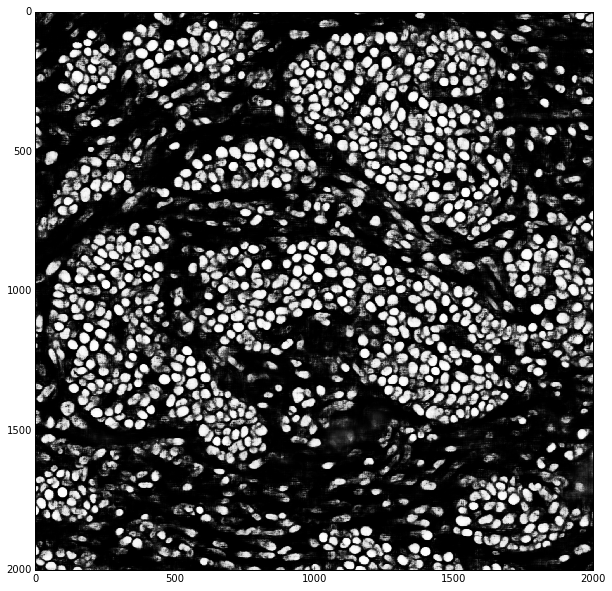

In [14]:
plt.imshow(result0)

In [15]:
scipy.misc.toimage(result0, cmin=0.0, cmax=1.0).save('recon_nn.tif')